# Classic U-Net segmentation model: Evaluation and Analysis

#### Import dependencies, set sweep IDs and fetch all runs from both sweeps

In [1]:
import wandb
import pandas as pd
import numpy as np

SWEEPS = [
    ("original", "tkshfj-bsc-computer-science-university-of-london", "classic_unet_segmentation", "1jpj8b17"),
    ("adaptive", "tkshfj-bsc-computer-science-university-of-london", "classic_unet_seg_adaptive", "l6eaiduh"),
    ("monai", "tkshfj-bsc-computer-science-university-of-london", "classic_unet_seg_mopnai", "wn8iqlox"),
]

api = wandb.Api()
all_runs = []

for label, entity, project, sweep_id in SWEEPS:
    print(f"Fetching runs for {label} sweep: {entity}/{project}/{sweep_id}")
    try:
        sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
        for run in sweep.runs:
            run_dict = dict(run.config)
            run_dict.update(run.summary)
            run_dict["run_id"] = run.id
            run_dict["sweep"] = label
            all_runs.append(run_dict)
    except Exception as e:
        print(f"Failed to fetch sweep {sweep_id}: {e}")

df = pd.DataFrame(all_runs)
df = df.drop_duplicates(subset=['run_id'])
df = df.reindex(sorted(df.columns), axis=1)

def compute_effective_lr(row):
    if pd.notnull(row.get('learning_rate')):
        return row['learning_rate']
    if pd.notnull(row.get('base_learning_rate')) and pd.notnull(row.get('lr_multiplier')):
        return row['base_learning_rate'] * row['lr_multiplier']
    if pd.notnull(row.get('base_learning_rate')):
        return row['base_learning_rate']
    return np.nan

df['effective_learning_rate'] = df.apply(compute_effective_lr, axis=1)

# Exclude private/internal columns
exclude_keys = [col for col in df.columns if col.startswith('_') or col == 'wandb_version']
df = df.drop(columns=exclude_keys, errors='ignore')

print("Total runs loaded:", len(df))
print(df.groupby('sweep')['run_id'].count())
print(df.head())

Fetching runs for original sweep: tkshfj-bsc-computer-science-university-of-london/classic_unet_segmentation/1jpj8b17
Fetching runs for adaptive sweep: tkshfj-bsc-computer-science-university-of-london/classic_unet_seg_adaptive/l6eaiduh
Fetching runs for monai sweep: tkshfj-bsc-computer-science-university-of-london/classic_unet_seg_mopnai/wn8iqlox
Failed to fetch sweep wn8iqlox: Could not find sweep <Sweep tkshfj-bsc-computer-science-university-of-london/classic_unet_seg_mopnai/wn8iqlox (Unknown State)>
Total runs loaded: 731
sweep
adaptive    261
original    470
Name: run_id, dtype: int64
   base_learning_rate  batch_size  best_epoch  best_val_loss  \
0                 NaN           4          11       1.164546   
1                 NaN           8           4       1.156289   
2                 NaN          16          37       1.147306   
3                 NaN          16          25       1.155290   
4                 NaN           8           7       1.152706   

   dice_coefficient

### Summary Table

In [2]:
summary = df.groupby("sweep")[["dice_coefficient", "iou_metric", "loss"]].describe().round(3)
display(summary)

dice_coefficient                                                   \
                    count   mean    std    min    25%    50%    75%    max   
sweep                                                                        
adaptive            261.0  0.561  0.009  0.546  0.552  0.566  0.570  0.576   
original            470.0  0.538  0.007  0.520  0.534  0.540  0.544  0.571   

         iou_metric         ...                 loss                       \
              count   mean  ...    75%    max  count   mean    std    min   
sweep                       ...                                             
adaptive      261.0  0.390  ...  0.399  0.405  261.0  1.127  0.019  1.097   
original      470.0  0.371  ...  0.375  0.401  470.0  1.167  0.013  1.109   

                                     
           25%    50%    75%    max  
sweep                                
adaptive  1.11  1.118  1.146  1.153  
original  1.16  1.164  1.179  1.202  

[2 rows x 24 columns]

### Find the Best Hyperparameters

In [3]:
# Choose the metric we want to maximize
metric = "iou_metric"  # Change as needed, e.g. 'val_accuracy', 'dice_coefficient', etc.

# Only consider runs with the metric present
df_with_metric = df[df[metric].notnull()]

if not df_with_metric.empty:
    best_run = df_with_metric.loc[df_with_metric[metric].idxmax()]
    print("Best Run:")
    print(best_run)

    # Try to get the run URL, reconstruct if not present
    if "url" in best_run:
        url = best_run["url"]
    else:
        # Fallback: build W&B run URL from known fields
        # Try to infer project/sweep from run['sweep'] label
        sweep_label = best_run['sweep']
        if sweep_label == 'original':
            project = "classic_unet_segmentation"
        elif sweep_label == 'adaptive':
            project = "classic_unet_seg_adaptive"
        else:
            project = "<unknown-project>"
        entity = "tkshfj-bsc-computer-science-university-of-london"
        url = f"https://wandb.ai/{entity}/{project}/runs/{best_run['run_id']}"
    print("URL:", url)
else:
    print(f"No runs found with metric '{metric}'.")

Best Run:
base_learning_rate                                                    0.0002
batch_size                                                                32
best_epoch                                                                38
best_val_loss                                                       1.092476
dice_coefficient                                                    0.575859
dropout                                                             0.164733
epoch                                                                     39
epochs                                                                    40
graph                      {'_type': 'graph-file', 'path': 'media/graph/g...
input_shape                                                    [256, 256, 1]
iou_metric                                                          0.405031
l2_reg                                                              0.000015
learning_rate                                                     

### Find the Best Model

In [4]:
# Find the run with the best validation Dice coefficient
best_run = df.loc[df['val_dice_coefficient'].idxmax()]

print("Best Hyperparameters and Result:")

selected_keys = [
    'batch_size', 
    'effective_learning_rate', 
    'dropout', 
    'l2_reg', 
    'val_dice_coefficient', 
    'val_iou_metric',
    'epochs',
    'sweep'
]
# Only select the columns that exist
present_keys = [k for k in selected_keys if k in df.columns]
print(best_run[present_keys])

# Reconstruct the W&B run URL
entity = "tkshfj-bsc-computer-science-university-of-london"
project = (
    "classic_unet_segmentation" 
    if best_run['sweep'] == "original" 
    else "classic_unet_seg_adaptive"
)
run_url = f"https://wandb.ai/{entity}/{project}/runs/{best_run['run_id']}"
print("W&B Run URL:", run_url)


Best Hyperparameters and Result:
batch_size                       32
effective_learning_rate    0.000181
dropout                    0.163745
l2_reg                     0.000055
val_dice_coefficient       0.584666
val_iou_metric              0.41372
epochs                           40
sweep                      adaptive
Name: 615, dtype: object
W&B Run URL: https://wandb.ai/tkshfj-bsc-computer-science-university-of-london/classic_unet_seg_adaptive/runs/2p6k0pz9


In [5]:
# Example: Show both LRs if available
lr_val = best_run.get("effective_learning_rate", None)
base_lr_val = best_run.get("base_learning_rate", None)
multiplier = best_run.get("lr_multiplier", None)

print("learning_rate:", lr_val)
print("base_learning_rate:", base_lr_val)
print("lr_multiplier:", multiplier)
if base_lr_val and multiplier:
    print("Effective learning rate:", float(base_lr_val) * float(multiplier))

learning_rate: 0.0001813460133544142
base_learning_rate: 0.0002
lr_multiplier: 0.906730066772071
Effective learning rate: 0.0001813460133544142


In [6]:
summary_rows = []
for sweep_label in df['sweep'].unique():
    subdf = df[df['sweep'] == sweep_label]
    if not subdf.empty:
        best = subdf.loc[subdf['val_dice_coefficient'].idxmax()]
        row = {k: best[k] for k in present_keys if k in best}
        row['run_url'] = (
            f"https://wandb.ai/tkshfj-bsc-computer-science-university-of-london/"
            f"{'classic_unet_segmentation' if sweep_label=='original' else 'classic_unet_seg_adaptive'}/runs/{best['run_id']}"
        )
        summary_rows.append(row)
pd.set_option('display.max_columns', None)
print(pd.DataFrame(summary_rows))

   batch_size  effective_learning_rate   dropout    l2_reg  \
0          16                 0.000235  0.175796  0.000216   
1          32                 0.000181  0.163745  0.000055   

   val_dice_coefficient  val_iou_metric  epochs     sweep  \
0              0.572673        0.402994      40  original   
1              0.584666        0.413720      40  adaptive   

                                             run_url  
0  https://wandb.ai/tkshfj-bsc-computer-science-u...  
1  https://wandb.ai/tkshfj-bsc-computer-science-u...  


### Visualize Effect of Hyperparameters on Performance

##### Discrete Parameter (batch_size)

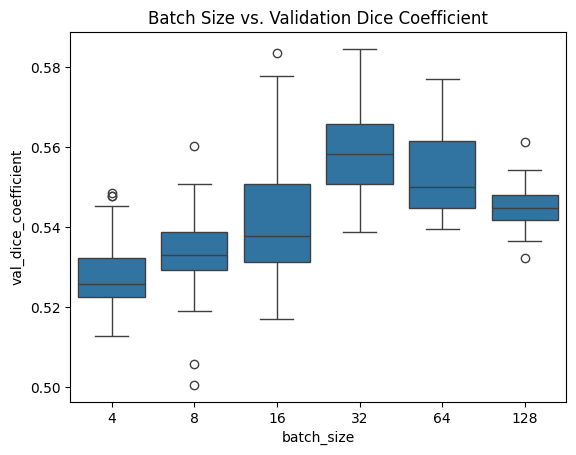

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='batch_size', y='val_dice_coefficient', data=df)
plt.title('Batch Size vs. Validation Dice Coefficient')
plt.show()

##### Continuous Parameters

##### Learning Rate

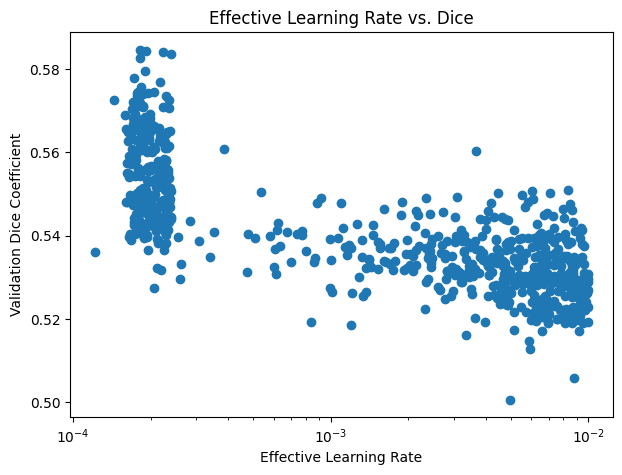

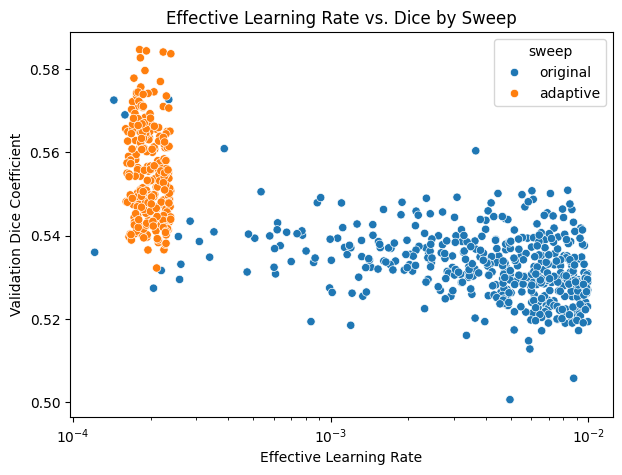

In [8]:
# Basic scatter plot (no sweep coloring)
plt.figure(figsize=(7, 5))
plt.scatter(df['effective_learning_rate'], df['val_dice_coefficient'])
plt.xscale('log')
plt.xlabel('Effective Learning Rate')
plt.ylabel('Validation Dice Coefficient')
plt.title('Effective Learning Rate vs. Dice')
plt.show()

# Color by sweep using seaborn for more insight
import seaborn as sns
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df,
    x='effective_learning_rate',
    y='val_dice_coefficient',
    hue='sweep'
)
plt.xscale('log')
plt.xlabel('Effective Learning Rate')
plt.ylabel('Validation Dice Coefficient')
plt.title('Effective Learning Rate vs. Dice by Sweep')
plt.show()

# plt.scatter(df['learning_rate'], df['val_dice_coefficient'])
# plt.xscale('log')
# plt.xlabel('Learning Rate')
# plt.ylabel('Validation Dice Coefficient')
# plt.title('Learning Rate vs. Dice')
# plt.show()

##### Dropout

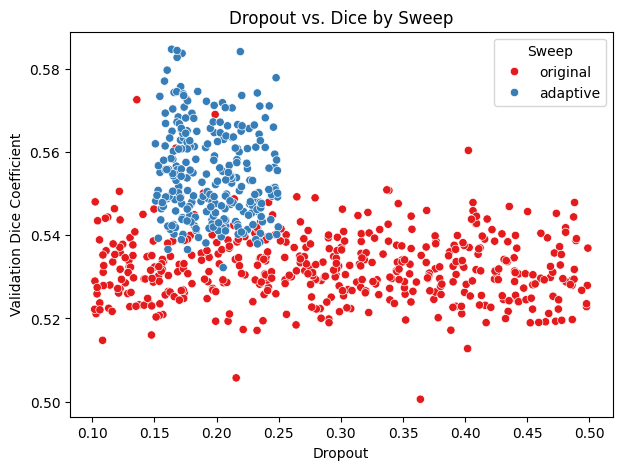

In [9]:
import seaborn as sns

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df,
    x='dropout',
    y='val_dice_coefficient',
    hue='sweep',
    palette='Set1'
)
plt.xlabel('Dropout')
plt.ylabel('Validation Dice Coefficient')
plt.title('Dropout vs. Dice by Sweep')
plt.legend(title='Sweep')
plt.show()

##### L2 Regularization

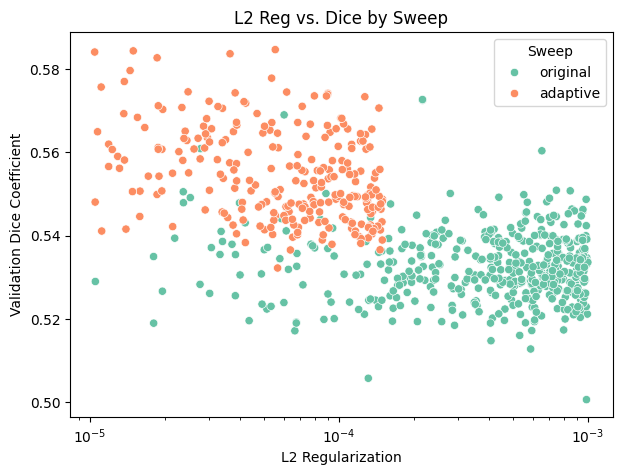

In [10]:
import seaborn as sns

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df,
    x='l2_reg',
    y='val_dice_coefficient',
    hue='sweep',
    palette='Set2'
)
plt.xscale('log')
plt.xlabel('L2 Regularization')
plt.ylabel('Validation Dice Coefficient')
plt.title('L2 Reg vs. Dice by Sweep')
plt.legend(title='Sweep')
plt.show()

### Aggregate Results (e.g., Group by a Hyperparameter)

In [11]:
# Ensure effective_learning_rate column exists
if 'effective_learning_rate' not in df.columns:
    def compute_effective_lr(row):
        if pd.notnull(row.get('learning_rate')):
            return row['learning_rate']
        if pd.notnull(row.get('base_learning_rate')) and pd.notnull(row.get('lr_multiplier')):
            return row['base_learning_rate'] * row['lr_multiplier']
        if pd.notnull(row.get('base_learning_rate')):
            return row['base_learning_rate']
        return np.nan
    df['effective_learning_rate'] = df.apply(compute_effective_lr, axis=1)

# Group by effective learning rate (exclude NaN LRs)
agg = df.dropna(subset=['effective_learning_rate']).groupby('effective_learning_rate')['val_dice_coefficient'].agg(['mean', 'std', 'max', 'count'])
print(agg)

                             mean  std       max  count
effective_learning_rate                                
0.000121                 0.535977  NaN  0.535977      1
0.000144                 0.572535  NaN  0.572535      1
0.000159                 0.568992  NaN  0.568992      1
0.000160                 0.565655  NaN  0.565655      1
0.000161                 0.548163  NaN  0.548163      1
...                           ...  ...       ...    ...
0.009920                 0.529470  NaN  0.529470      1
0.009926                 0.530879  NaN  0.530879      1
0.009932                 0.528855  NaN  0.528855      1
0.009934                 0.526925  NaN  0.526925      1
0.009946                 0.519318  NaN  0.519318      1

[731 rows x 4 columns]


In [12]:
# Make sure 'effective_learning_rate' column exists
if 'effective_learning_rate' not in df.columns:
    def compute_effective_lr(row):
        if pd.notnull(row.get('learning_rate')):
            return row['learning_rate']
        if pd.notnull(row.get('base_learning_rate')) and pd.notnull(row.get('lr_multiplier')):
            return row['base_learning_rate'] * row['lr_multiplier']
        if pd.notnull(row.get('base_learning_rate')):
            return row['base_learning_rate']
        return np.nan
    df['effective_learning_rate'] = df.apply(compute_effective_lr, axis=1)

# Group by effective_learning_rate and aggregate val_iou_metric
agg = (
    df.dropna(subset=['effective_learning_rate'])
      .groupby('effective_learning_rate')['val_iou_metric']
      .agg(['mean', 'std', 'max', 'count'])
)
print(agg)

                             mean  std       max  count
effective_learning_rate                                
0.000121                 0.367552  NaN  0.367552      1
0.000144                 0.402860  NaN  0.402860      1
0.000159                 0.399307  NaN  0.399307      1
0.000160                 0.394880  NaN  0.394880      1
0.000161                 0.377755  NaN  0.377755      1
...                           ...  ...       ...    ...
0.009920                 0.361953  NaN  0.361953      1
0.009926                 0.362840  NaN  0.362840      1
0.009932                 0.360925  NaN  0.360925      1
0.009934                 0.361716  NaN  0.361716      1
0.009946                 0.354949  NaN  0.354949      1

[731 rows x 4 columns]


### Plot Metric vs. Hyperparameter

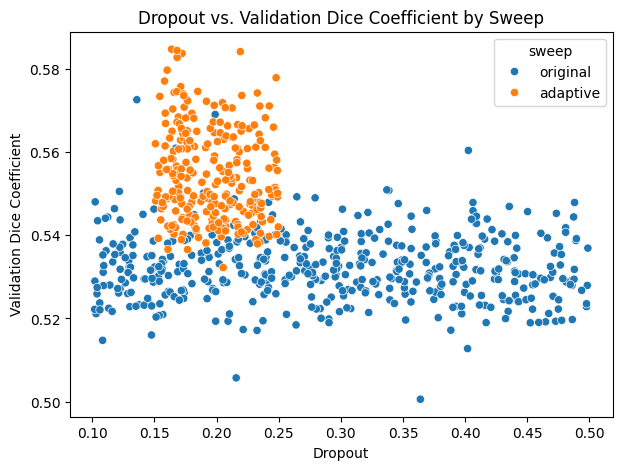

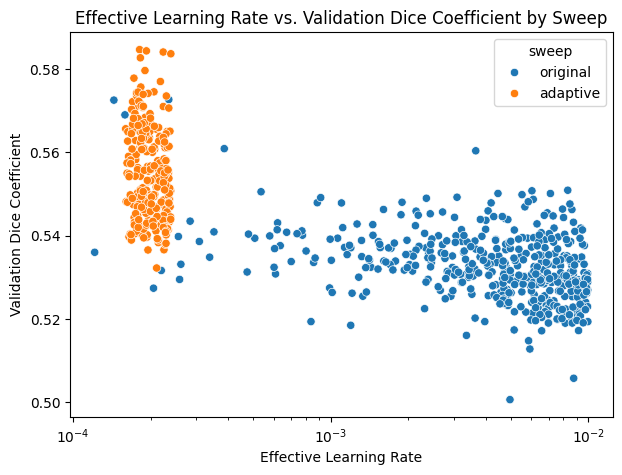

In [13]:
import seaborn as sns

plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x='dropout', y='val_dice_coefficient', hue='sweep')
plt.xlabel('Dropout')
plt.ylabel('Validation Dice Coefficient')
plt.title('Dropout vs. Validation Dice Coefficient by Sweep')
plt.show()

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df,
    x='effective_learning_rate',
    y='val_dice_coefficient',
    hue='sweep'
)
plt.xscale('log')
plt.xlabel('Effective Learning Rate')
plt.ylabel('Validation Dice Coefficient')
plt.title('Effective Learning Rate vs. Validation Dice Coefficient by Sweep')
plt.show()

# plt.figure(figsize=(7, 5))
# sns.scatterplot(data=df, x='learning_rate', y='val_dice_coefficient', hue='sweep')
# plt.xscale('log')
# plt.xlabel('Learning Rate')
# plt.ylabel('Validation Dice Coefficient')
# plt.title('Learning Rate vs. Validation Dice Coefficient by Sweep')
# plt.show()

### Analyze Top N Runs

In [14]:
top_n = 10
top = df.sort_values('val_dice_coefficient', ascending=False).head(top_n).copy()  # .copy() to avoid SettingWithCopyWarning

cols = [
    'batch_size', 
    'learning_rate', 
    'base_learning_rate', 
    'lr_multiplier', 
    'effective_learning_rate',
    'dropout', 
    'l2_reg', 
    'val_dice_coefficient', 
    'run_id', 
    'sweep'
]

present_cols = [c for c in cols if c in top.columns]

# Make a URL column
entity = "tkshfj-bsc-computer-science-university-of-london"
def get_url(row):
    project = "classic_unet_segmentation" if row['sweep'] == "original" else "classic_unet_seg_adaptive"
    return f"https://wandb.ai/{entity}/{project}/runs/{row['run_id']}"

top['url'] = top.apply(get_url, axis=1)

print(top[present_cols + ['url']])

# Print in a readable format as well
for _, row in top.iterrows():
    print("="*60)
    print(f"val_dice_coefficient: {row['val_dice_coefficient']:.4f}")
    print(f"run_id: {row['run_id']}")
    print(f"sweep: {row['sweep']}")
    print(f"learning_rate: {row.get('learning_rate', None)}")
    print(f"base_learning_rate: {row.get('base_learning_rate', None)}")
    print(f"lr_multiplier: {row.get('lr_multiplier', None)}")
    print(f"effective_learning_rate: {row.get('effective_learning_rate', None)}")
    print(f"url: {row['url']}")


     batch_size  learning_rate  base_learning_rate  lr_multiplier  \
615          32            NaN              0.0002       0.906730   
729          32            NaN              0.0002       0.963390   
479          32            NaN              0.0002       1.119558   
661          16            NaN              0.0002       1.198597   
707          32            NaN              0.0002       0.912893   
558          32            NaN              0.0002       0.951280   
708          16            NaN              0.0002       0.861845   
703          64            NaN              0.0002       1.091804   
591          32            NaN              0.0002       0.916756   
533          32            NaN              0.0002       1.030808   

     effective_learning_rate   dropout    l2_reg  val_dice_coefficient  \
615                 0.000181  0.163745  0.000055              0.584666   
729                 0.000193  0.168199  0.000015              0.584366   
479               

### Aggregate by Batch Size (or Other Parameter)

In [15]:
agg = df.groupby('batch_size')['val_dice_coefficient'].agg(['mean', 'std', 'max', 'count'])
print(agg)

                mean       std       max  count
batch_size                                     
4           0.527762  0.007330  0.548700    148
8           0.533879  0.007351  0.560361    164
16          0.542046  0.013690  0.583671    219
32          0.559447  0.010743  0.584666     79
64          0.553337  0.010847  0.577007     59
128         0.544928  0.004805  0.561428     62


### Parallel Coordinates for Multivariate Exploration

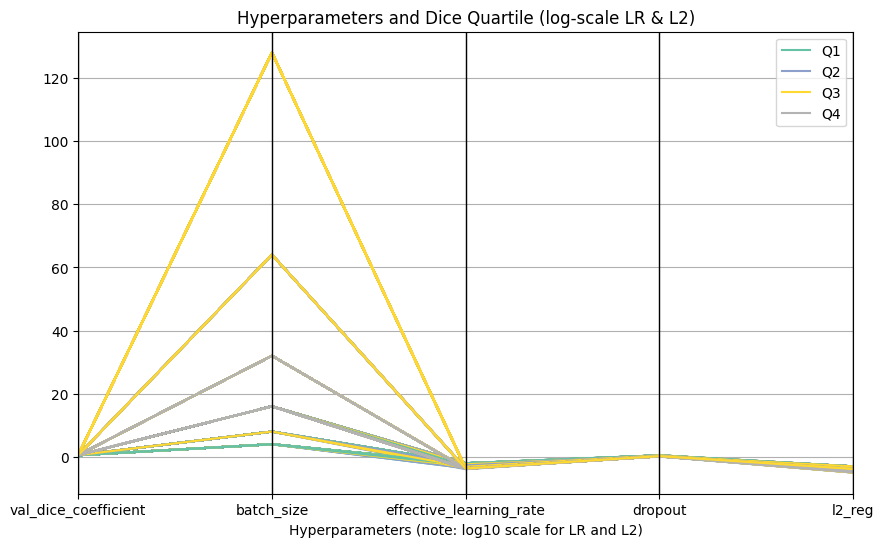

In [16]:
from pandas.plotting import parallel_coordinates

# Always use effective_learning_rate for analysis
cols = ['val_dice_coefficient', 'batch_size', 'effective_learning_rate', 'dropout', 'l2_reg']
data = df[cols].dropna().copy()

# Discretize Dice for coloring (quartiles)
data['dice_cat'] = pd.qcut(data['val_dice_coefficient'], 4, labels=['Q1','Q2','Q3','Q4'])

# (Optional) log-scale for learning rate and l2_reg
data['effective_learning_rate'] = np.log10(data['effective_learning_rate'])
data['l2_reg'] = np.log10(data['l2_reg'])

plt.figure(figsize=(10,6))
parallel_coordinates(data, 'dice_cat', colormap=plt.get_cmap("Set2"))
plt.title('Hyperparameters and Dice Quartile (log-scale LR & L2)')
plt.xlabel('Hyperparameters (note: log10 scale for LR and L2)')
plt.show()


### Find the Most Consistent Hyperparameter

In [17]:
print(df[['val_dice_coefficient', 'effective_learning_rate', 'dropout', 'l2_reg']].corr())

                         val_dice_coefficient  effective_learning_rate  \
val_dice_coefficient                 1.000000                -0.666292   
effective_learning_rate             -0.666292                 1.000000   
dropout                             -0.367958                 0.357998   
l2_reg                              -0.519431                 0.504943   

                          dropout    l2_reg  
val_dice_coefficient    -0.367958 -0.519431  
effective_learning_rate  0.357998  0.504943  
dropout                  1.000000  0.284603  
l2_reg                   0.284603  1.000000  


### Export Data to CSV/Excel

In [18]:
df.to_csv("wandb_sweep_results.csv", index=False)

### Summary: How to Evaluate

- Best config: Look for the run with the max val_dice_coefficient.

- Parameter impact: Plot Dice vs. each hyperparameter, aggregate results by batch size.

- Top runs: Print best runs for easy model checkpoint access.

- Multivariate effects: Use parallel coordinates to view how combinations affect performance.